In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import numpy as np
import pickle
import rbm,utilities
import pandas as pd
import RBM_utils,MNIST_utils,dataset_utils

dataset_utils.load_MNIST(globals()) # train_data, test_data, train_labels, test_labels




../source/numba_utilities.py:14: NumbaWarning: Cannot cache compiled function "dot_Potts_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:32: NumbaWarning: Cannot cache compiled function "dot_Potts2_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:50: NumbaWarning: Cannot cache compiled function "dot_Potts3_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:91: NumbaWarning: Cannot cache compiled function "compute_output_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:113: NumbaWarning: Cannot cache compiled function "c

# Visualize some MNIST samples

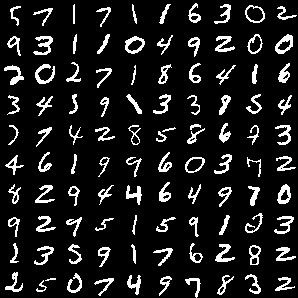

In [6]:
MNIST_utils.show_samples( train_data[100:200])

# Train a simple RBM model
- Training
- Compute some performance metric on test set (pseudo-likelihood)
- Show the Markov Chains used throughout training (Persistent Contrastive Divergence, see Fischer & Igel)

Test set pseudo-likelihood -0.100


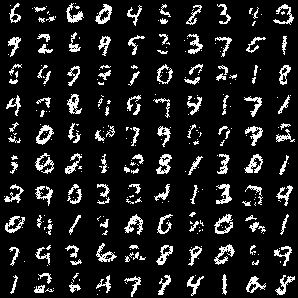

In [7]:
RBM = rbm.RBM(n_v = 784, n_h = 100 ,visible='Bernoulli',hidden='Bernoulli') # Specifiy number of visible units, hidden units, hidden units type

RBM.fit(train_data,n_iter=10,batch_size=100,nchains=100,N_MC=1,N_PT=1, # Training options: mini-batch size, number of epochs over data
                         verbose = 0)

print('Test set pseudo-likelihood %.3f'%(RBM.pseudo_likelihood(test_data).mean()) )

MNIST_utils.show_samples(RBM.fantasy_v) # Show the Markov chains used in the training

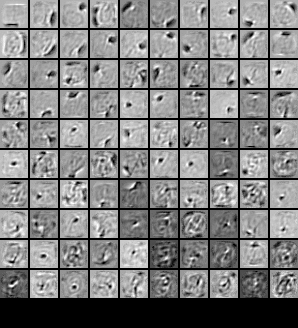

In [8]:
MNIST_utils.show_weights(RBM,sort='beta') # Show the weights columns for each hidden unit, sorted by their amplitude

# Generate a Markov chain

Mismatch dimensions (100, 100), [2, 100], reinitializating I
Mismatch dimensions (100, 784), [2, 784], reinitializating I
(2, 225, 784)


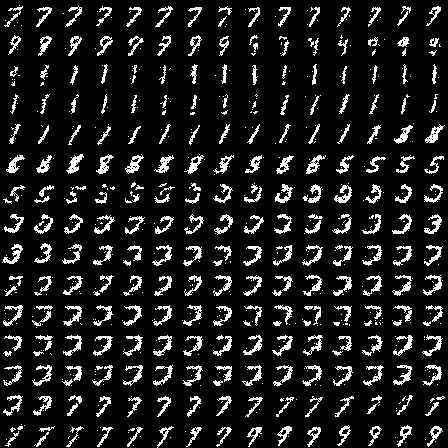

In [9]:
# Generate a single markov chain:
datav,datah = RBM.gen_data(Nchains=2, # Number of independent Markov chains
                           Lchains=225, # Length of each Markov chain
                           Nthermalize=1000, # Number of thermalization steps before starting to record.
                           Nstep = 20, # Number of Markov Updates between each sample
                          reshape = False) # Returns a Nchains X Lchains X 784 tensor.

print(datav.shape)

MNIST_utils.show_samples(datav[0]) # The first chain

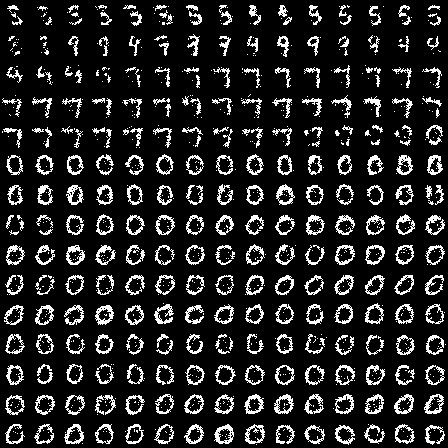

In [11]:
MNIST_utils.show_samples(datav[1]) # The second chain

# Obtaining better looking digits: More elaborate training with bigger RBM

../source/layer.py:1189: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))
../source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))
../source/layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
../source/layer.py:1151: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


-0.05539141
Test set pseudo-likelihood -0.053


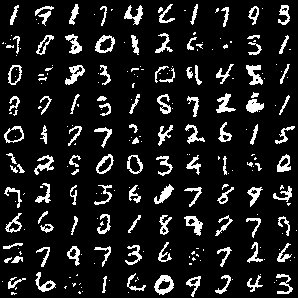

In [13]:
RBM2 = rbm.RBM(n_v = 784,n_h=400, visible='Bernoulli',hidden='dReLU') # Better training - but slower.
RBM2.fit(train_data,verbose=0,N_MC=10,n_iter=20)

print(RBM2.pseudo_likelihood(train_data).mean() )

MNIST_utils.show_samples(RBM2.fantasy_v) # Show the Markov chains used in the training


print('Test set pseudo-likelihood %.3f'%RBM2.pseudo_likelihood(test_data).mean() )

MNIST_utils.show_samples(RBM2.fantasy_v) # Show the Markov chains used in the training

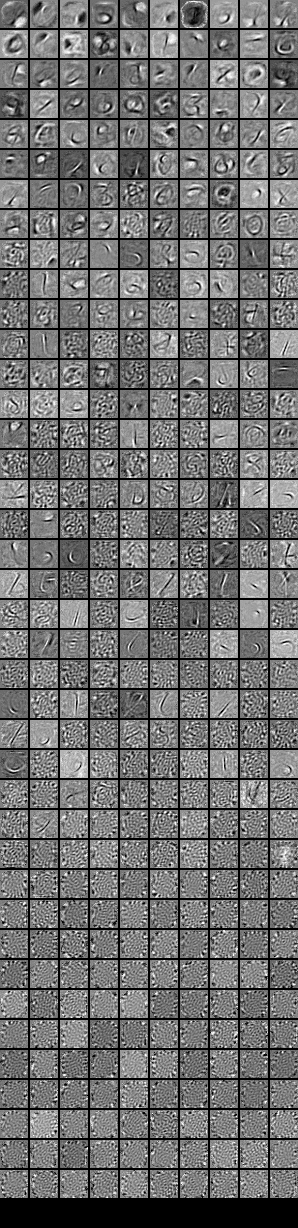

In [14]:
MNIST_utils.show_weights(RBM2,sort='beta') # Show the weights columns for each hidden unit, sorted by their amplitude

Mismatch dimensions (100, 400), [2, 400], reinitializating I
Mismatch dimensions (100, 784), [2, 784], reinitializating I


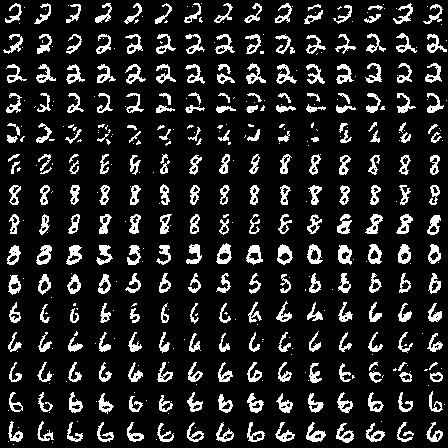

In [15]:
datav,datah = RBM2.gen_data(Nchains=2, # Number of independent Markov chains
                           Lchains=225, # Length of each Markov chain
                           Nthermalize=1000, # Number of thermalization steps before starting to record.
                           Nstep = 20, # Number of Markov Updates between each sample
                          reshape = False) # Returns a Nchains X Lchains X 784 tensor.

MNIST_utils.show_samples(datav[0]) # The first chain

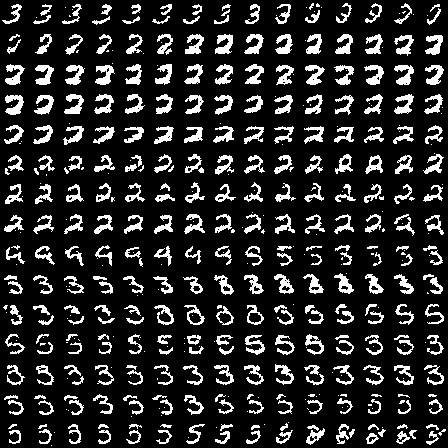

In [16]:
MNIST_utils.show_samples(datav[1]) # The second chain

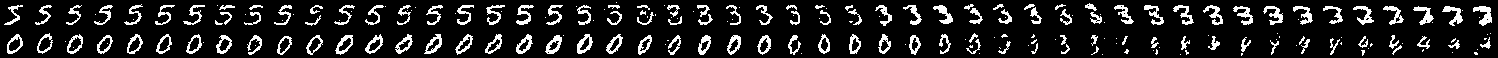

In [18]:
#### Start from given sample digit

datav_initial = train_data[:2]
# datav_initial = train_data[0][np.newaxis,:] # Caution: must provide (Nchains X Nv) matrix; not (Nv) vector. Use np.newaxis if only one initial condition.

Nchains = datav_initial.shape[0]
Lchains = 50

datav2,datah2 = RBM2.gen_data(Nthermalize=0,Nchains=Nchains,Lchains=Lchains,config_init=datav_initial,reshape=False,Nstep=20)

MNIST_utils.show_samples(datav2.reshape([Nchains*Lchains,784]),tile_shape=[Nchains,Lchains])


Mismatch dimensions (2, 400), [10, 400], reinitializating I
Mismatch dimensions (2, 784), [10, 784], reinitializating I


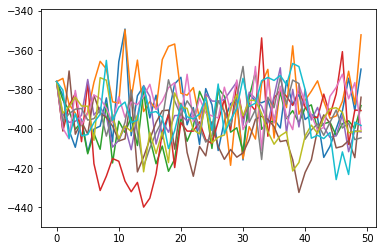

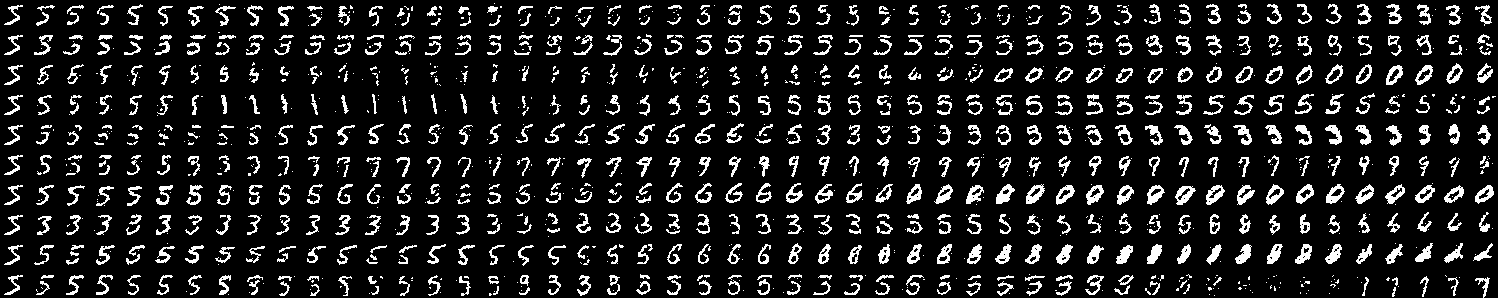

In [19]:
#### 10 MC starting from the same digit.

datav_initial = np.repeat(train_data[0][np.newaxis,:],10,axis=0)

Nchains = datav_initial.shape[0]
Lchains = 50

datav2,datah2 = RBM2.gen_data(Nthermalize=0,Nchains=Nchains,Lchains=Lchains,config_init=datav_initial,reshape=False,Nstep=20)

## Visualize energy of trajectory.

F = RBM2.free_energy(datav2.reshape([Nchains*Lchains,784]) ).reshape([Nchains,Lchains]).T # Input must be (Ndata X Nv) matrix.

ylim = [F.min()-10,F.max()+10]

plt.plot(F); plt.ylim(ylim); plt.show()

MNIST_utils.show_samples(datav2.reshape([Nchains*Lchains,784]),tile_shape=[Nchains,Lchains])






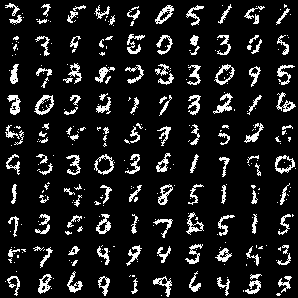

In [21]:
weights =  1.0 + np.mod(train_labels,2) # give more weight to odd numbers
RBM = rbm.RBM(n_v = 784,n_h=100, visible='Bernoulli',hidden='Bernoulli')
RBM.fit(train_data,verbose=0,weights=weights)
MNIST_utils.show_samples(RBM.fantasy_v) # Show the Markov chains used in the training

In [34]:
import layer,importlib; importlib.reload(layer); importlib.reload(bm)

<module 'bm' from '../source/bm.py'>

In [ ]:
import bm
BM = bm.BM(N=784,nature='Bernoulli') # Train pairwise model
BM.fit(train_data)
MNIST_utils.show_samples(BM.fantasy_x) # Show the Markov chains used in the training

Iteration number 0, pseudo-likelihood: -0.26
Starting epoch 1
[BM] Iteration 1, pseudo-likelihood = -0.08, time = 14.49s
Starting epoch 2
[BM] Iteration 2, pseudo-likelihood = -0.07, time = 13.67s
Starting epoch 3
[BM] Iteration 3, pseudo-likelihood = -0.07, time = 16.37s
Starting epoch 4
[BM] Iteration 4, pseudo-likelihood = -0.07, time = 14.14s
Starting epoch 5
[BM] Iteration 5, pseudo-likelihood = -0.06, time = 12.12s
Starting epoch 6
[BM] Iteration 6, pseudo-likelihood = -0.06, time = 15.03s
Starting epoch 7
[BM] Iteration 7, pseudo-likelihood = -0.06, time = 17.01s
Starting epoch 8
[BM] Iteration 8, pseudo-likelihood = -0.06, time = 13.95s
Starting epoch 9
[BM] Iteration 9, pseudo-likelihood = -0.06, time = 14.65s
Starting epoch 10


In [ ]:
RBM = rbm.RBM(n_v = 784,n_h=100, visible='Bernoulli',hidden='Gaussian') # Pairwise model with low rank interaction matrix
RBM.fit(data_mnist,verbose=0)

MNIST_utils.show_samples(RBM.fantasy_v) # Show the Markov chains used in the training

Observe that none of the pairwise model can reproduce accuractely digits, compared to model with non-linear hidden units. The BM models has high pseudo-likelihood, but bad likelihood

In [ ]:
i = 550 # Visualize some couplings of BM on MNIST
plt.imshow(BM.layer.couplings[:,i].reshape([28,28]),vmin=-0.5,vmax=0.5,interpolation='none'); plt.colorbar(); 
plt.title('Coupling pixel %s <-> all others'%i); plt.show()
i = 650
plt.imshow(BM.layer.couplings[:,i].reshape([28,28]),vmin=-0.5,vmax=0.5,interpolation='none'); plt.colorbar(); 
plt.title('Coupling pixel %s <-> all others'%i)
plt.show()
plt.hist(BM.layer.couplings.flatten(),bins=100); plt.title('Histogram of all couplings')